Running the autoencoder compression using standarized flowers dataset
]

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

path = "images"
dataset = datasets.ImageFolder(path, transform=transform)

size = len(dataset)
train_size = int(0.85*size)
test_size = size - train_size

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class Autoencoder128(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),   # 3x128x128 -> 32x64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64x32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 128x16x16
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# 256x8x8
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 512x4x4
            nn.Flatten(),
            nn.Linear(512*4*4, latent_dim)  # latent vector
        )

        # ---------- Decoder ----------
        self.fc2 = nn.Linear(latent_dim, 512*4*4)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512*4*4),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [20]:
def train_autoencoder(loader, latent_dim=256, epochs=20, lr=1e-3):
  model = Autoencoder128(latent_dim=latent_dim).to(device)

  criterion = nn.MSELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
      total_loss = 0.0
      for imgs, _ in loader:
          imgs = imgs.to(device)

          optimizer.zero_grad()
          outputs, _ = model(imgs)
          loss = criterion(outputs, imgs)

          loss.backward()
          optimizer.step()

          total_loss += loss.item() * imgs.size(0)

      epoch_loss = total_loss / len(loader.dataset)
      print(f"Epoch {epoch+1}/{epochs} | Loss = {loss.item():.4f}")
  return model

In [22]:
def eval_model(model, dataloader):
  model.eval()
  compressed_vectors = []
  originals = []
  reconstructions = []

  with torch.no_grad():
      for imgs, _ in dataloader:
          imgs = imgs.to(device)
          outputs, compressed = model(imgs)
          compressed_vectors.append(compressed.cpu())
          originals.append(imgs.cpu())
          reconstructions.append(outputs.cpu())

  compressed_vectors = torch.cat(compressed_vectors)
  originals = torch.cat(originals)
  reconstructions = torch.cat(reconstructions)

  mse = F.mse_loss(reconstructions, originals)
  print(f"MSE: {mse.item():.6f}")

  return mse, (originals, compressed_vectors, reconstructions)

In [31]:
model256 = train_autoencoder(train_loader)
torch.save(model256.state_dict(), "AE256_20epochs.pth")
mse, v256 = eval_model(model256, test_loader)

Epoch 1/20 | Loss = 44175.6680
Epoch 2/20 | Loss = 27220.6484
Epoch 3/20 | Loss = 21491.4258
Epoch 4/20 | Loss = 26258.0254
Epoch 5/20 | Loss = 20604.0469
Epoch 6/20 | Loss = 20065.2656
Epoch 7/20 | Loss = 20670.8125
Epoch 8/20 | Loss = 20251.7168
Epoch 9/20 | Loss = 18964.9746
Epoch 10/20 | Loss = 13059.7900
Epoch 11/20 | Loss = 19479.3633
Epoch 12/20 | Loss = 16175.1377
Epoch 13/20 | Loss = 15848.8711
Epoch 14/20 | Loss = 15966.0840
Epoch 15/20 | Loss = 19547.6094
Epoch 16/20 | Loss = 13410.8779
Epoch 17/20 | Loss = 17300.6309
Epoch 18/20 | Loss = 16986.9766
Epoch 19/20 | Loss = 10802.8770
Epoch 20/20 | Loss = 14977.9082
MSE: 0.021404


In [32]:
model512 = train_autoencoder(train_loader, latent_dim=512)
torch.save(model512.state_dict(), "AE512_20epochs.pth")
mse, v512 = eval_model(model512, test_loader)
mse

Epoch 1/20 | Loss = 41799.2656
Epoch 2/20 | Loss = 32107.7695
Epoch 3/20 | Loss = 26153.0742
Epoch 4/20 | Loss = 21813.7305
Epoch 5/20 | Loss = 21569.2207
Epoch 6/20 | Loss = 16242.5371
Epoch 7/20 | Loss = 21825.3320
Epoch 8/20 | Loss = 19015.8848
Epoch 9/20 | Loss = 19246.2227
Epoch 10/20 | Loss = 13874.0918
Epoch 11/20 | Loss = 15007.7354
Epoch 12/20 | Loss = 20551.3828
Epoch 13/20 | Loss = 21252.9980
Epoch 14/20 | Loss = 16332.1523
Epoch 15/20 | Loss = 20495.1055
Epoch 16/20 | Loss = 15469.5410
Epoch 17/20 | Loss = 14467.1475
Epoch 18/20 | Loss = 15955.2578
Epoch 19/20 | Loss = 15730.4893
Epoch 20/20 | Loss = 14232.3828
MSE: 0.021113


tensor(0.0211)

In [33]:
model1024 = train_autoencoder(train_loader, latent_dim=1024)
torch.save(model1024.state_dict(), "AE1024_20epochs.pth")
mse, v1024 = eval_model(model1024, test_loader)

Epoch 1/20 | Loss = 33957.6211
Epoch 2/20 | Loss = 26936.8750
Epoch 3/20 | Loss = 25035.5820
Epoch 4/20 | Loss = 28742.4219
Epoch 5/20 | Loss = 18147.7227
Epoch 6/20 | Loss = 20254.8984
Epoch 7/20 | Loss = 22108.0059
Epoch 8/20 | Loss = 18811.4727
Epoch 9/20 | Loss = 18765.8496
Epoch 10/20 | Loss = 19042.8008
Epoch 11/20 | Loss = 17791.0469
Epoch 12/20 | Loss = 25148.0625
Epoch 13/20 | Loss = 15470.8936
Epoch 14/20 | Loss = 22881.8613
Epoch 15/20 | Loss = 16330.3340
Epoch 16/20 | Loss = 17867.9180
Epoch 17/20 | Loss = 14205.0469
Epoch 18/20 | Loss = 14220.7676
Epoch 19/20 | Loss = 16123.0254
Epoch 20/20 | Loss = 15786.9648
MSE: 0.021320


In [34]:
model2048 = train_autoencoder(train_loader, latent_dim=2048)
torch.save(model2048.state_dict(), "AE2048_20epochs.pth")
mse, v2048 = eval_model(model2048, test_loader)

Epoch 1/20 | Loss = 36650.9531
Epoch 2/20 | Loss = 34311.4883
Epoch 3/20 | Loss = 30338.9863
Epoch 4/20 | Loss = 27033.1289
Epoch 5/20 | Loss = 23394.8711
Epoch 6/20 | Loss = 21644.4238
Epoch 7/20 | Loss = 22566.4102
Epoch 8/20 | Loss = 24993.0879
Epoch 9/20 | Loss = 19250.5664
Epoch 10/20 | Loss = 21018.5410
Epoch 11/20 | Loss = 17186.5957
Epoch 12/20 | Loss = 17061.9180
Epoch 13/20 | Loss = 16658.8535
Epoch 14/20 | Loss = 14413.0898
Epoch 15/20 | Loss = 17914.8477
Epoch 16/20 | Loss = 17507.2109
Epoch 17/20 | Loss = 12366.2109
Epoch 18/20 | Loss = 13806.8320
Epoch 19/20 | Loss = 13691.0938
Epoch 20/20 | Loss = 16664.9453
MSE: 0.022725


In [35]:
model128 = train_autoencoder(train_loader, latent_dim=128)
torch.save(model128.state_dict(), "AE128_20epochs.pth")
mse, v128 = eval_model(model128, test_loader)

Epoch 1/20 | Loss = 37243.8281
Epoch 2/20 | Loss = 34719.9648
Epoch 3/20 | Loss = 22039.8066
Epoch 4/20 | Loss = 26768.6270
Epoch 5/20 | Loss = 25489.4355
Epoch 6/20 | Loss = 16657.0566
Epoch 7/20 | Loss = 21977.7031
Epoch 8/20 | Loss = 20384.7637
Epoch 9/20 | Loss = 13242.0156
Epoch 10/20 | Loss = 17439.4805
Epoch 11/20 | Loss = 17512.6094
Epoch 12/20 | Loss = 15905.6836
Epoch 13/20 | Loss = 17447.4023
Epoch 14/20 | Loss = 13048.7656
Epoch 15/20 | Loss = 14685.4570
Epoch 16/20 | Loss = 14804.4170
Epoch 17/20 | Loss = 17241.3359
Epoch 18/20 | Loss = 15874.9902
Epoch 19/20 | Loss = 16685.8516
Epoch 20/20 | Loss = 13601.3291
MSE: 0.021653


Text(0.5, 1.0, 'Impact of latent dimension size on MSE of test data')

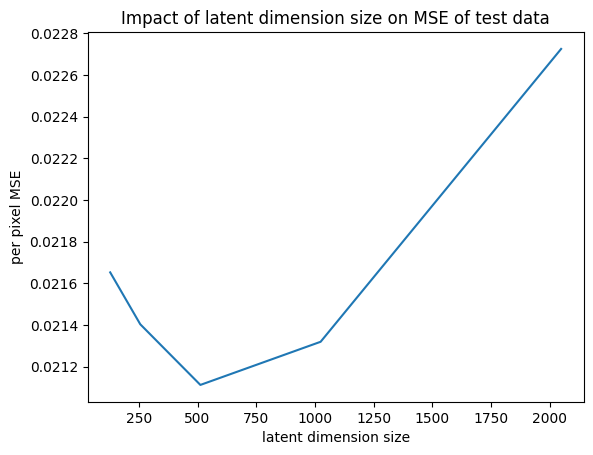

In [64]:
latent_dims = [128, 256, 512, 1024, 2048]
mses = [0.021653, 0.021404, 0.021113, 0.021320, 0.022725]
plt.plot(latent_dims, mses)
plt.ylabel("per pixel MSE")
plt.xlabel("latent dimension size")
plt.title("Impact of latent dimension size on MSE of test data")

In [46]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def batch_ssim(originals, reconstructions):
    originals = originals.permute(0,2,3,1).cpu().numpy()  # N,H,W,3
    reconstructions = reconstructions.permute(0,2,3,1).cpu().numpy()
    ssims = []
    for a,b in zip(originals, reconstructions):
        # skimage expects float images in [0,1] (or 0-255) and multichannel=True
        score = ssim(a, b, data_range=1.0, multichannel=True, channel_axis=-1)
        ssims.append(score)
    return np.array(ssims)


Text(0.5, 1.0, 'Impact of latent dimension size on mean SSIM of test data')

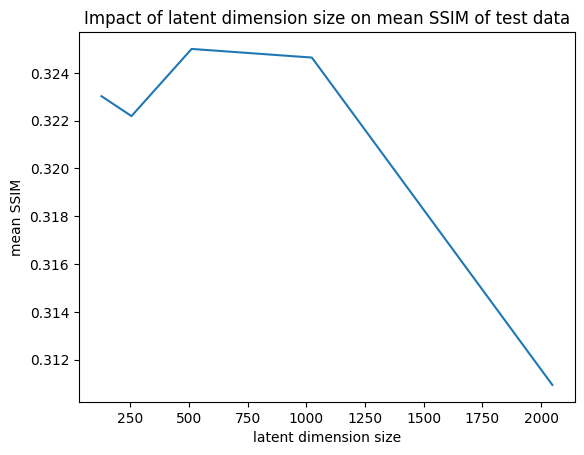

In [63]:
outputs = [v128, v256, v512, v1024, v2048]
ssims = []
for output in outputs:
  ssims.append(batch_ssim(output[0], output[2]).mean())

plt.plot(latent_dims, ssims)
plt.ylabel("mean SSIM")
plt.xlabel("latent dimension size")
plt.title("Impact of latent dimension size on mean SSIM of test data")

In [60]:
# Selecting a random image from test set for visual inspection
_, representative_image = torch.utils.data.random_split(test_set, [test_size-1, 1])
loader = DataLoader(representative_image)

In [59]:
def show_imgs(originals, reconstructions, num_to_show=5):
  for i in range(num_to_show):
    plt.figure(figsize=(6,3))
    # Original
    plt.subplot(1,2,1)
    plt.imshow(originals[i].permute(1,2,0))
    plt.title("Original")
    plt.axis('off')
    # Reconstructed
    plt.subplot(1,2,2)
    plt.imshow(reconstructions[i].permute(1,2,0))
    plt.title("Reconstructed")
    plt.axis('off')
    plt.show()

Latent Dimension Size:  128
MSE: 0.024340
SSIM:  0.20150487


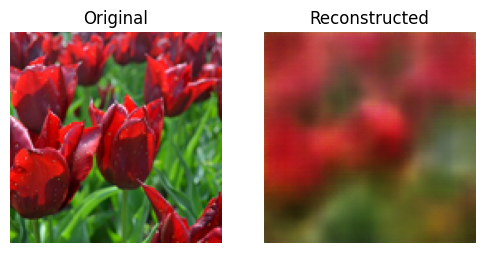

Latent Dimension Size:  256
MSE: 0.024629
SSIM:  0.19917655


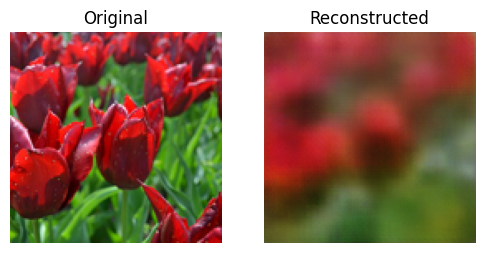

Latent Dimension Size:  512
MSE: 0.024717
SSIM:  0.19702224


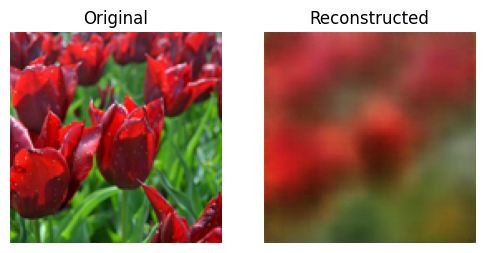

Latent Dimension Size:  1024
MSE: 0.025835
SSIM:  0.18921585


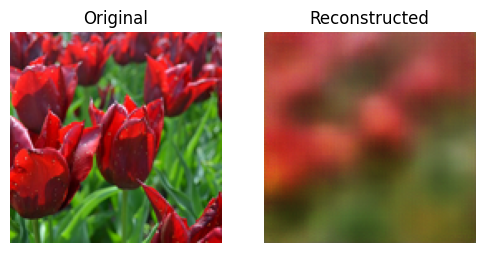

Latent Dimension Size:  2048
MSE: 0.025811
SSIM:  0.18723428


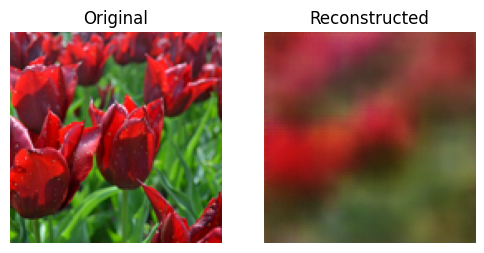

In [62]:
models = [model128, model256, model512, model1024, model2048]
for model, dim in zip(models, latent_dims):
  print("Latent Dimension Size: ", dim)
  mse, v = eval_model(model, loader)
  print("SSIM: ", batch_ssim(v[0], v[2]).mean())
  show_imgs(v[0], v[2], num_to_show=1)